# Imports

In [1]:
import os
import numpy as np
import pandas as pd
import subprocess
import pickle
import matplotlib.pyplot as plt
from concurrent.futures import ProcessPoolExecutor
import shutil
plt.rcParams['axes.facecolor']='white'

In [2]:
# Create directory and subdirectories for results of 1000 resamples
os.makedirs('resamples', exist_ok=True)
for i in range(1000):
    # create path for this resample
    sub_dir = os.path.join('resamples', str(i))
    # create subdirectory with clade analysis results subdirectories
    sub_dir_CC = os.path.join(sub_dir, 'clade_analyses_CC')
    sub_dir_AB = os.path.join(sub_dir, 'clade_analyses_AB')
    os.makedirs(sub_dir_CC, exist_ok=True)
    os.makedirs(sub_dir_AB, exist_ok=True)

In [3]:
# stableCoalescence_cladeAnalysis.py
def run_simulation(i):
    # add subdirectory for resample output in the simulation direcory
    simulation_id = f"{i:04d}" 
    output_path = os.path.join("./simulations", simulation_id, "resample_output")
    # Remove the output directory if it exists
    if os.path.exists(output_path):
        shutil.rmtree(output_path)
    # (Re)create the output directory
    os.makedirs(output_path)
    # run the simulation
    command = [
        "python3",
        "stableCoalescence_cladeAnalysis.py",
        "-tn", os.path.join("./simulations", simulation_id, "transmission_network.subsampled.txt.gz"),
        "-tt", os.path.join("./simulations", simulation_id, "tree.time.subsampled.nwk.gz"),
        "-g", os.path.join("./simulations", simulation_id, "GEMF_files/output.txt.gz"),
        "-s", "0.00092", # mutation rate
        "-m", "1", # number of mutations for clade analysis 
        "-o", output_path #output
    ]
    subprocess.run(command)

In [4]:
# resample each of the 1100 simulations
with ProcessPoolExecutor(max_workers=4) as executor:
    executor.map(run_simulation, range(1, 1101))

# Primary analysis (3.47-day doubling time, 15% ascertainment rate) tree sizes

In [5]:
def read_clade_results(dir):
    clade_analyses_d = dict()
    for path in sorted(os.listdir(dir)): # pool all clade analyses together
        clade_analysis_path = dir + path
        key = int(path.split('_')[0])
        clade_analyses_d[key] = {'clade_sizes': [], 'subclade_sizes': []}
        for line in open(clade_analysis_path):
            l = line.strip().strip(']').split('[')
            clade_size = int(l[0].strip()) # make each clade size (including single leaves) an integer
            subclade_sizes = [int(x) for x in l[1].strip().replace(' ', '').split(',')] # put each subclade size (including single leaves) into a list
            clade_analyses_d[key]['clade_sizes'].append(clade_size)
            clade_analyses_d[key]['subclade_sizes'].append(subclade_sizes)
    return clade_analyses_d

In [6]:
clade_analyses_CC_dir = './resamples/0/clade_analyses_CC/'
clade_analyses_AB_dir = './resamples/0/clade_analyses_AB/'

clade_analyses_CC_d = read_clade_results(clade_analyses_CC_dir)

print('Less than 787 taxa: %f' % (sum([sum(clade_analyses_CC_d[x]['clade_sizes']) < 787 for x in clade_analyses_CC_d])/1100)) 
print('More than 1000 taxa: %f' % (sum([sum(clade_analyses_CC_d[x]['clade_sizes']) > 1000 for x in clade_analyses_CC_d])/1100))
print('More than 5000 taxa: %f' % (sum([sum(clade_analyses_CC_d[x]['clade_sizes']) > 5000 for x in clade_analyses_CC_d])/1100))

Less than 787 taxa: 0.014545
More than 1000 taxa: 0.983636
More than 5000 taxa: 0.967273


# Tree shapes and bayes factors

In [7]:
unconstrained_results = np.array([1.68,80.85, 10.32, 0.92])/100 # linB, linA, C/C, T/T
recCA_results = np.array([77.28, 8.18, 10.49, 3.71])/100 # linB, linA, C/C, T/T

In [8]:
def calculate_bf(asr_results, simulation_results):
    # Let t_p be a polytomy, t_1C be one clade, and t_2c be two clades. Note that t_p is a topology with a polytomy but is not t_1c. t_p + t_1c equals all topologies with a basal polytomy (Fig. 2a). 
    # trees are in the order
    # (t_p, t_1C, t_2C, (t_p,(t_p,t_1C,t_2C)), (t_1C,(t_p,t_1C,t_2C)), (t_2c,(t_p,t_1C,t_2C)))
    compatibility_matrix = np.array([np.array([0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0]), # S_A
                                     np.array([0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0]), # S_B
                                     np.array([0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0]), # S_CC
                                     np.array([0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0])] # S_TT
                                    )
                                    
    # A matrix of conditional probabilities
    # Each row stores the vector Pr(S_MRCA | \btau)
    pr_s_mrca_given_tree = np.array([x/sum(x) if sum(x) > 0 else x for x in compatibility_matrix.T]) # if tree not associated with any haplotype, just keep the row as all 0s
    
    # Order: S_A, S_B, S_{C/C}, S_{T/T}
    pr_s_mrca_given_data = np.array(asr_results)/sum(asr_results)
    unnormalized_pr_data_given_s_mrca = pr_s_mrca_given_data.copy()
    
    # FAVITES simulation information
    # the 3 trees are in the order (t_p, t_1C, t_2C)
    pr_3_topos = np.array(simulation_results)
    pr_trees_given_I1 = np.concatenate([pr_3_topos, np.array([0]*9)])
    pr_trees_given_I2 = np.concatenate([np.array([0]*3), np.outer(pr_3_topos, pr_3_topos).flatten()])
    
    # Equal prior probability of 1 or 2 intros
    pr_I1 = 0.5
    pr_I2 = 0.5
    
    pr_s_mrca_and_I1 = np.dot([np.dot(pr_s_mrca_given_tree.T[i], pr_trees_given_I1) for i in range(0,4)], pr_I1) # dot product of P(haplotype|tree) (column) and P(trees|I_n), scaled by P(I_n)
    pr_s_mrca_and_I2 = np.dot([np.dot(pr_s_mrca_given_tree.T[i], pr_trees_given_I2) for i in range(0,4)], pr_I2)

    posterior_odds = np.dot(unnormalized_pr_data_given_s_mrca, pr_s_mrca_and_I2) / np.dot(unnormalized_pr_data_given_s_mrca, pr_s_mrca_and_I1)
    prior_odds = pr_I2/pr_I1
    BF = posterior_odds/prior_odds

    return(BF)



In [9]:
def clade_analysis_updated(clade_analyses_CC_dir, clade_analyses_AB_dir, label, min_polytomy_size=100, _print_=False):
    # C/C analyses focus on 1-mutation clades
    # therefore, all descendant lineages are included:
    #   -1 = unmutated leaf
    #    1 = mutated leaf separate from a clade
    #   >1 = clade
    clade_analyses_CC_d = read_clade_results(clade_analyses_CC_dir)

    # A/B analyses focus on 2-mutation clades
    # only 2-mutation clades are included 
    clade_analyses_AB_d = read_clade_results(clade_analyses_AB_dir)
    
    # C/C analysis
    cc_count_30perc_twoPolytomies = 0 # how often are there only two 1-mutation clades, each constituting more than 30% of taxa AND with a polytomy at the base of each clade, and no other descendants from the root?
    for run in clade_analyses_CC_d:
        clade_sizes = clade_analyses_CC_d[run]['clade_sizes'] # get the clade sizes
        subclade_sizes = [len(x)>=min_polytomy_size for x in clade_analyses_CC_d[run]['subclade_sizes']] # check if each clade has a polytomy at the base
        if len(clade_sizes) == 2: # if there are more than two descendants, including individual leaves, skip
            if min(clade_sizes) > (sum(clade_sizes)*0.30): # make sure each clade is >30%
                if False not in subclade_sizes: # each clade must have a polytomy at the base
                    cc_count_30perc_twoPolytomies += 1
    
    # A/B analysis
    ab_count_30perc_twoPolytomies = 0 # interested in 2 mutations clade that are at least 30% of all taxa + has a basal polytomy + polytomy at 2 mutation clade
    lower_constraint = 0.3 # the 2-mutation clade must be at least 30% of all taxa
    upper_constraint = 0.7 # the 2-mutation clade must be at most 70% of all taxa

    for run in clade_analyses_AB_d:
        num_leaves = sum(clade_analyses_CC_d[run]['clade_sizes'])
        base_polytomy_size = len(clade_analyses_CC_d[run]['clade_sizes']) # check how many lineages descend from the root
        clade_sizes = clade_analyses_AB_d[run]['clade_sizes'] 
        subclade_sizes = clade_analyses_AB_d[run]['subclade_sizes']
        if not clade_sizes: # no 2 mutation clades
            continue
        for index, clade_size in enumerate(clade_sizes): # loop through all 2 mutation clades
            if lower_constraint*num_leaves <= clade_size <= upper_constraint*num_leaves: # clade match size restrictions
                if base_polytomy_size >= min_polytomy_size: # basal polytomy
                    if len(subclade_sizes[index]) >= min_polytomy_size: # polytomy at 2 mutation clade
                        ab_count_30perc_twoPolytomies += 1 # if all conditions are met, add 1 to the count
                        break # if one 2 mutation clade meets the conditions, break out of the loop and move on to the next run

    # polytomy: checking if there is a polytomy at the base of the tree; can do this using the C/C analysis
    min_polytomy_descendants = min_polytomy_size
    count_atLeastMinDescendants = 0
    for run in clade_analyses_CC_d: # loop through all runs
        clade_sizes = clade_analyses_CC_d[run]['clade_sizes'] # get the clade sizes
        if len(clade_sizes) >= min_polytomy_descendants:  # if there are at least X number of descendants, including individual leaves
            count_atLeastMinDescendants += 1
    polytomy_result = count_atLeastMinDescendants/1100
    
    # calculate bayes factors
    cc_result = cc_count_30perc_twoPolytomies/1100
    ab_result = ab_count_30perc_twoPolytomies/1100

    simulation_results = [polytomy_result-ab_result, ab_result, cc_result] # note that polytomy result is inclusive of ab_result, so subtract ab_result from polytomy_result to avoid double counting
    unconstrained_results = np.array([1.68, 80.85, 10.32, 0.92])/100 # linA, linB, C/C, T/T
    recCA_results = np.array([77.28, 8.18, 10.49, 3.71])/100 # linA, linB, C/C, T/T
    bf_unconstrained = calculate_bf(unconstrained_results, simulation_results)
    bf_recCA = calculate_bf(recCA_results, simulation_results)
    
    if _print_ == True:
        print('Proportion with a polytomy at the base: %f\n' % (count_atLeastMinDescendants/1100))
        print('C/C clade analysis: 2 clades, polytomy at base of each clade, each clade possessing at least 30%% of the taxa: %f\n' % (cc_count_30perc_twoPolytomies/1100))
        print('A/B clade analysis: Basal polytomy, polytomy at 2-mut clade, with the clade possessing between 30 and 70%% of the taxa: %f\n' % (ab_count_30perc_twoPolytomies/1100))
        print('Unconstrained Bayes factor: %f' % bf_unconstrained)
        print('recCA Bayes factor: %f' % bf_recCA)

    #return [label, min_polytomy_size, "{:.1f}".format(cc_result*100), "{:.1f}".format(ab_result*100), "{:.1f}".format(polytomy_result*100), "{:.1f}".format(bf_unconstrained), "{:.1f}".format(bf_recCA)]
    return [cc_count_30perc_twoPolytomies, ab_count_30perc_twoPolytomies, count_atLeastMinDescendants, bf_unconstrained, bf_recCA]



### Main result

In [10]:
cc_counts = []
ab_counts = []
polytomy_counts = []
bf_unconstrained_results = []
bf_recCA_results = []

for i in range (1000):
    clade_analyses_CC_dir = './resamples/' + str(i) + '/clade_analyses_CC/'
    clade_analyses_AB_dir = './resamples/' + str(i) + '/clade_analyses_AB/'
    a, b, c, d, e = clade_analysis_updated(clade_analyses_CC_dir, clade_analyses_AB_dir, '3.5 DT', min_polytomy_size=100)
    cc_counts.append(a)
    ab_counts.append(b)
    polytomy_counts.append(c)
    bf_unconstrained_results.append(d)
    bf_recCA_results.append(e)

In [11]:
# confirm counts of published data
# set counts so that frequencies and BFs match published notebook data
pub_polytomy_count = 523 # published freq 0.475455
pub_cc_count = 0 # published freq 0
pub_ab_count = 34 # published freq 0.030909
# setup simulation result list
pub_sim_results = [pub_polytomy_count/1100-pub_ab_count/1100, pub_ab_count/1100, pub_cc_count/1100]
# setup BEAST result list
unconstrained_results = np.array([1.68, 80.85, 10.32, 0.92])/100 # linA, linB, C/C, T/T
recCA_results = np.array([77.28, 8.18, 10.49, 3.71])/100 # linA, linB, C/C, T/T
# get BFs
pub_bf_unconstrained = calculate_bf(unconstrained_results, pub_sim_results)
pub_bf_recCA = calculate_bf(recCA_results, pub_sim_results)
# print results
print('Proportion with a polytomy at the base: %f' % (pub_polytomy_count/1100))
print('Proportion C/C topology: %f' % (pub_cc_count/1100))
print('Proportion A/B topology: %f' % (pub_ab_count/1100))
print('Unconstrained Bayes factor: %f' % pub_bf_unconstrained)
print('recCA Bayes factor: %f' % pub_bf_recCA)

Proportion with a polytomy at the base: 0.475455
Proportion C/C topology: 0.000000
Proportion A/B topology: 0.030909
Unconstrained Bayes factor: 4.154836
recCA Bayes factor: 4.264418


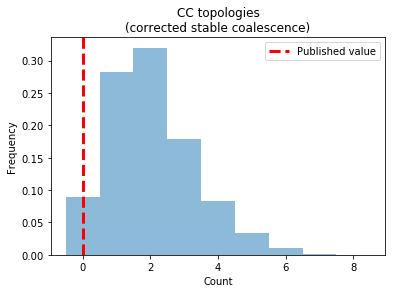

In [12]:
weights = [1.0 / len(cc_counts)] * len(cc_counts)
# Plot the histogram
plt.hist(cc_counts, bins=np.arange(-0.5, 9, 1), weights=weights, alpha = 0.5)  
plt.title('CC topologies\n(corrected stable coalescence)')
plt.xlabel('Count')
plt.ylabel('Frequency')

# Show published value
plt.axvline(x=pub_cc_count, color='r', linestyle='dashed', linewidth=3, label='Published value')

# Omit expected value (mean), as the distribution makes it redundant
mean_CC = np.mean(cc_counts)
# plt.axvline(x=mean_CC, color='g', linestyle='dashed', linewidth=3, label='Expected value')

plt.legend()

plt.savefig('cc_resample_distribution_corrected_sc.png')

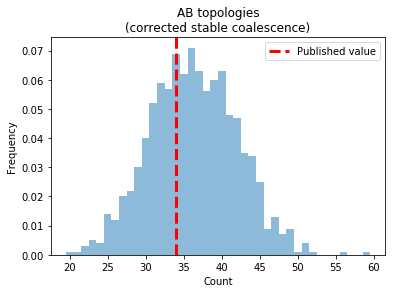

In [13]:
weights = [1.0 / len(ab_counts)] * len(ab_counts)
# Plot the histogram
plt.hist(ab_counts, bins=np.arange(19.5, 60, 1), weights=weights, alpha = 0.5)  
plt.title('AB topologies\n(corrected stable coalescence)')
plt.xlabel('Count')
plt.ylabel('Frequency')

# Show published value
plt.axvline(x=pub_ab_count, color='r', linestyle='dashed', linewidth=3, label='Published value')

# Omit expected value (mean), as the distribution makes it redundant
mean_AB = np.mean(ab_counts)
# plt.axvline(x=mean_AB, color='g', linestyle='dashed', linewidth=3, label='Expected value')

plt.legend()

plt.savefig('ab_resample_distribution_corrected_sc.png')

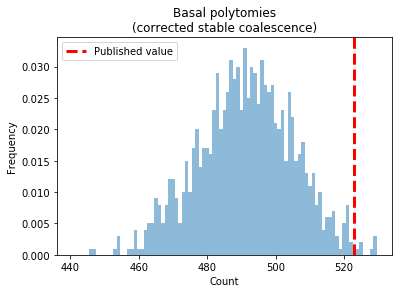

In [19]:
weights = [1.0 / len(polytomy_counts)] * len(polytomy_counts)
# Plot the histogram
plt.hist(polytomy_counts, bins=np.arange(440.5, 530, 1), weights=weights, alpha = 0.5)  
plt.title('Basal polytomies\n(corrected stable coalescence)')
plt.xlabel('Count')
plt.ylabel('Frequency')

# Show published value
plt.axvline(x=pub_polytomy_count, color='r', linestyle='dashed', linewidth=3, label='Published value')

# Omit expected value (mean), as the distribution makes it redundant
mean_polytomy = np.mean(polytomy_counts)
# plt.axvline(x=mean_polytomy, color='g', linestyle='dashed', linewidth=3, label='Expected value')

plt.legend()

plt.savefig('polytomy_resample_distribution_corrected_sc.png')

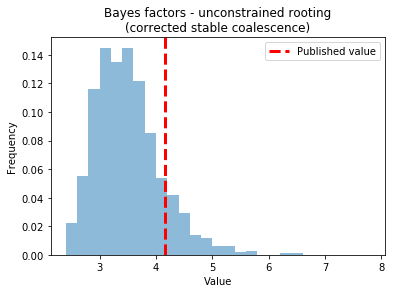

In [15]:
weights = [1.0 / len(bf_unconstrained_results)] * len(bf_unconstrained_results)
# Plot the histogram
plt.hist(bf_unconstrained_results, bins=np.arange(2.4, 8, 0.2), weights=weights, alpha = 0.5)  
plt.title('Bayes factors - unconstrained rooting\n(corrected stable coalescence)')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Show published value
plt.axvline(x=pub_bf_unconstrained, color='r', linestyle='dashed', linewidth=3, label='Published value')

# Omit expected value (mean), as the distribution makes it redundant
mean_unc = np.mean(bf_unconstrained_results)
# plt.axvline(x=mean_unc, color='g', linestyle='dashed', linewidth=3, label='Expected value')

plt.legend()

plt.savefig('unc_BF_resample_distribution_corrected_sc.png')

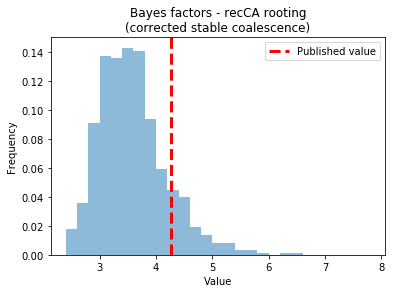

In [16]:
weights = [1.0 / len(bf_recCA_results)] * len(bf_recCA_results)
# Plot the histogram
plt.hist(bf_recCA_results, bins=np.arange(2.4, 8, 0.2), weights=weights, alpha = 0.5) 
plt.title('Bayes factors - recCA rooting\n(corrected stable coalescence)')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Show published value
plt.axvline(x=pub_bf_recCA, color='r', linestyle='dashed', linewidth=3, label='Published value')

# Omit expected value (mean), as the distribution makes it redundant
mean_recCA = np.mean(bf_recCA_results)
# plt.axvline(x=mean_recCA, color='g', linestyle='dashed', linewidth=3, label='Expected value')

plt.legend()

plt.savefig('recCA_BF_resample_distribution_corrected_sc.png')

In [18]:
# Convert means to topology likelihoods for the Bayes factor calculation
mean_simulation_results = np.array([mean_polytomy - mean_AB, mean_AB, mean_CC]) / 1100

# Setup the MRCA haplotype posterior probabilities for the Bayes factor calculation
unconstrained_results = np.array([1.68, 80.85, 10.32, 0.92])/100  
recCA_results = np.array([77.28, 8.18, 10.49, 3.71])/100  

# Calculate Bayes factors
bf_unconstrained = calculate_bf(unconstrained_results, mean_simulation_results)
bf_recCA = calculate_bf(recCA_results, mean_simulation_results)

print(f'expected polytomy rate: {mean_polytomy}')
print(f'expected AB rate: {mean_AB}')
print(f'expected CC rate: {mean_CC}')
print(f'expected BF (unconstrained): {mean_unc}')
print(f'expected BF (recCA): {mean_recCA}')
print(f'BF of expected rates (unconstrained): {bf_unconstrained}')
print(f'BF of exptected rates (recCA): {bf_recCA}')


expected polytomy rate: 491.402
expected AB rate: 36.287
expected CC rate: 2.035
expected BF (unconstrained): 3.4967090229091236
expected BF (recCA): 3.5826949956249536
BF of expected rates (unconstrained): 3.410732953966616
BF of exptected rates (recCA): 3.4948611110996026
